
# Business Data Analytics Challenge: Prediction of Electricity Flows

  

Fabio Costa;  Laurin Eichberger;  Nevena Nikolajevic;  Ömer Özumerzifon;  Lukas Petry;  Hendrik Scherner  


In [17]:
# Disable all warnings in this notebook to improve readability. 
import warnings
warnings.simplefilter("ignore")

## 1. Domain Understanding

### Predict the cross-border power flow between Germany and its neighbors

#### European integration of electricity market creates

* the need to predict the physical net current flow of Germany to the neighboring countries  
* and enable energy companies to adequately manage their production capacities. 


Goal of this project is to develop a ML-based model that can reliably perform the predictions based on publicly available data input.  
 

#### Output requirements of the model:   
* Time stamp with hourly granularity   
* Net electricity flow per country  


The model is not trained again before the input of future data and shall therefore be generalizable.  


Quality indicator of the prediction is quantity-weighted RSME.  

### Possible Influences 
First step was a brainstorming about the possible influence factors without specifying potential data sources and required formats. Afterwards we clustered the factors into a mind-map.   

The main factor categories we identified are:  
* Market-related data
* Physical restrictions  
* Production and Weather data  

Besides data related to Germany, the influence factors can always be extended to neighboring countries, this means that most of the identified factors exist for every other country and could thus be used as further input for training our model.   

However, our main independent variables are related to Germany, improved by weather data from neighboring countries.   


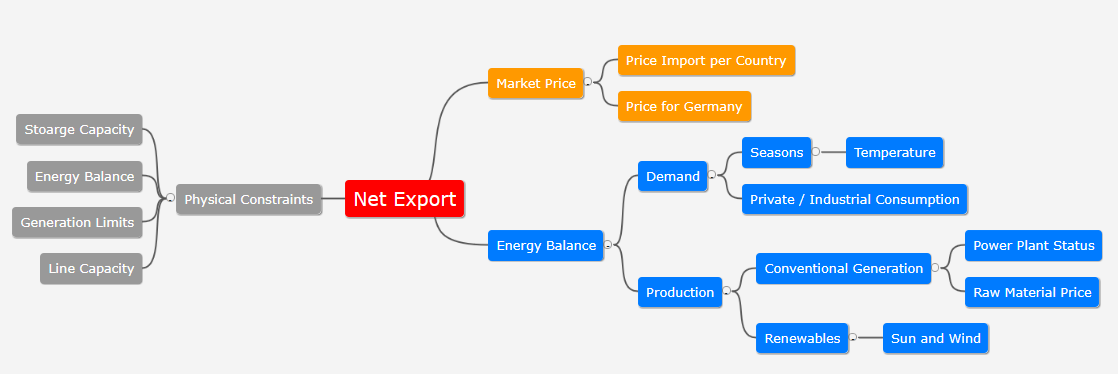

In [18]:
from IPython.display import IFrame    
img_path="./img/mindmap_schick.png"
from IPython.display import Image
Image(img_path)


In [19]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

----

## 2. Data Gathering

### Machine Learning Pipeline

<br>

<img src="img/Struktur_v2.png">

<br>

### Data sources

We found the following data to be publicly available: 

<br>


|Extracted Data | Source |
|:-------------:|:------:|
| Net Electricity Flow | SMARD, CEPS |
| Production forecast | SMARD, CEPS,RTE |
| Consumption forecast | SMARD, xyz |
| Realized Prodcution | SMARD, xyz |
| Realized consumption | SMARD, xyz |
| Price Data | SMARD, xyz |
| Weather | DWD, DMI, <br>   LFBD, LKPR <br> RTE, CEPS |

<br>

| Data Source | Availability |
|:-----------:|:------------:|
|SMARD| June 2015 - June 2019|
|DWD| June 2015 - June 2019|
|DMI| June 2015 - June 2019|
|LFBD|January 2017 - June 2019|
|LKPR|January 2017 - June 2019|
|CEPS|July 2017 - June 2019|
|RTE| July 2017 - June 2019|

<br>
<br>

Abbreviations:
```
DWD (German Meteorological Institute)  
DMI (Danish Meteorological Institute)  
LFBD (Airport Bordeaux)  
LKPR (Airport Prague)  
RTE (Réseau de transport d'électricité)  
CEPS (Czech transmission system provider)  
```

---

## 3. Data Analysis & Preprocessing
   

### 3.1 General Analysis

In [33]:
# Use Bokeh to interactively explore the data. 

from bda_bokeh import bda_bokeh
df = bda_bokeh.import_data()
df = bda_bokeh.preprocessing(df)
bda_bokeh.show_bokeh(df)

Import File: DE_Physikalischer Stromfluss_201506010000_201706012359_1.csv 
Import File: DE_Physikalischer Stromfluss_201706020000_201906022359_1.csv 


Loading BokehJS ...

INFO:bokeh.io.state:Session output file 'bda_bokeh.html' already exists, will be overwritten.


---

### 3.2 Time Series Analysis

Iteratively analyze and preprocess the data to create a master dataframe that contains valid, coherent and useful data.
<br>

<img src="img/Preprocessing_v2.png">

<br>

In [34]:
export_columns = [col for col in df.columns if col[-2::]=='EX' ]
import_columns = [col for col in df.columns if col[-2::]=='IM' ]

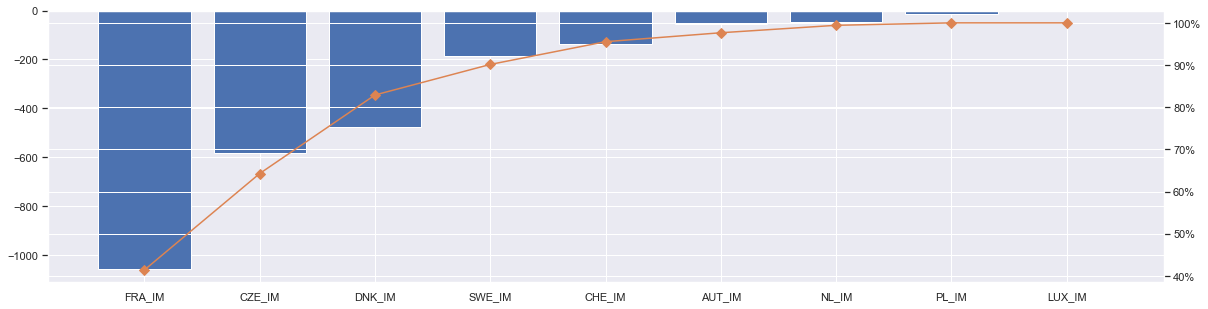

In [35]:
# Understand which countries contribute the most to the overall power flow. 

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd

import_data = pd.DataFrame(df[import_columns].mean().sort_values(ascending=True),columns=["mean_import"])
import_data['cum_percentage'] = (import_data.cumsum()/import_data.sum())*100

fig, ax = plt.subplots(figsize=[20,5])
ax.bar(import_data.index,import_data.mean_import)
    
ax2 = ax.twinx()
ax2.plot(import_data.index,import_data.cum_percentage, color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

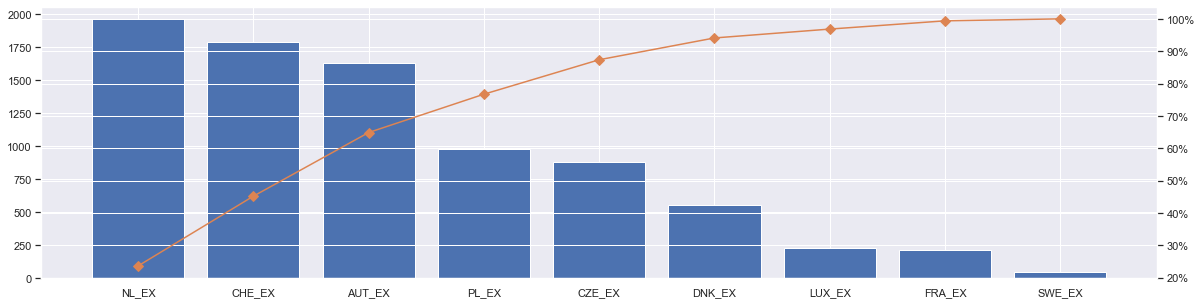

In [36]:
export_data = pd.DataFrame(df[export_columns].mean().sort_values(ascending=False),columns=["mean_import"])
export_data['cum_percentage'] = (export_data.cumsum()/export_data.sum())*100

fig, ax = plt.subplots(figsize=[20,5])
ax.bar(export_data.index,export_data.mean_import)
    
ax2 = ax.twinx()
ax2.plot(export_data.index,export_data.cum_percentage, color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

---

### 3.3 Correlation

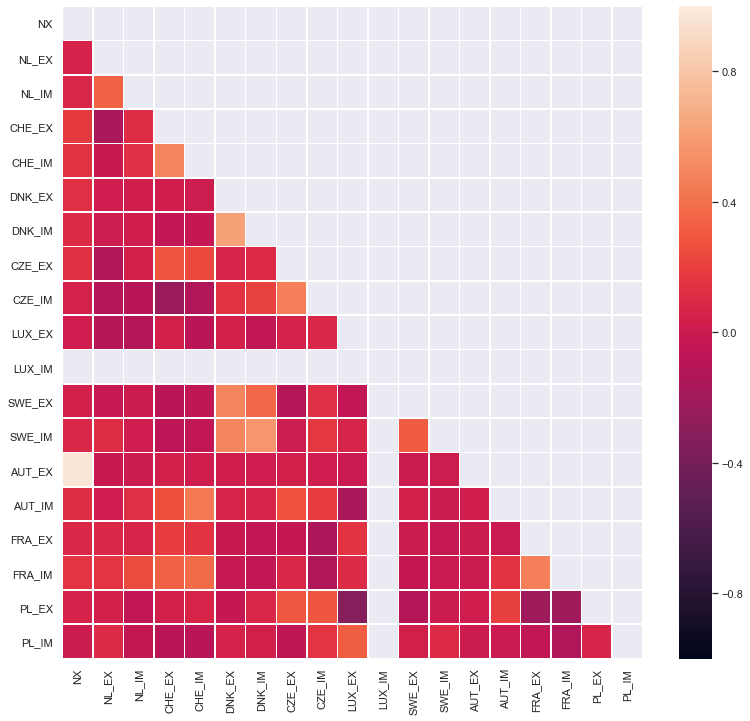

In [26]:
# Check if there are strong correlations between countries. 

import numpy as np
import seaborn as sns
sns.set()

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(13, 12)
mask = np.zeros_like(df.loc[:,'NX':'PL_IM'].corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(df.loc[:,'NX':'PL_IM'].corr(),mask=mask,vmin=-1,vmax=1,linewidths=.5)

### Results of Data Analysis and Preprocessing
* There are transport capacities for every border
* The data exhibits high seasonality and low trend
* Import mostly depends on France, Czech Republic and Denmark
* Export mostly depends on the Netherlands, Czech Republic and Austria 
* Strong one-hour auto-correlation

---

## 4. Model

### 4.1 Possible Models

A evaluation of available forecasting methods leads to the following selection of promising candidates.
<br>

<img src="img/possible_models_v6.png" width="900px">

<br>

### 4.2 Auto-Regressive Decomposition Model: FBProphet

A decomposition of linear components with Facebook's Prophet creates additional insights. 

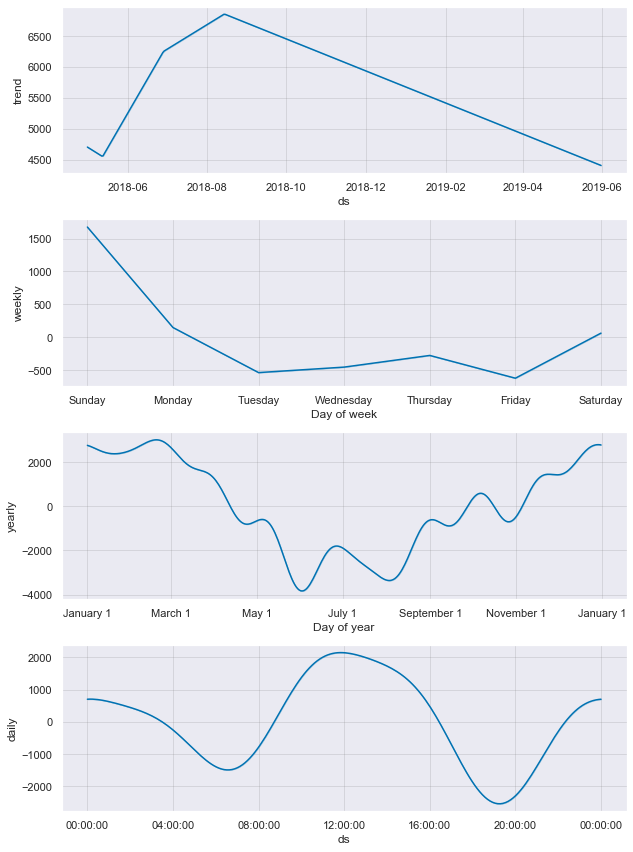

In [27]:
from model.prophet import bda_prophet
from fbprophet import Prophet
import pandas as pd
from datetime import datetime


country_codes = bda_prophet.extract_country_codes(df)
df = bda_prophet.get_net_export(df, country_codes, ["EX","IM"])

df_NX = df[['Date', 'NX']]
df_NX = bda_prophet.rename_columns_for_prophet(df_NX)

m = Prophet()
m.fit(df_NX)

future = pd.DataFrame({"ds": pd.date_range(start=datetime(2018,5,1), end=datetime(2019,5,31,23,0,0))})
forecast = m.predict(future) 
fig2 = m.plot_components(forecast)

----

## 4.3 Deep Nets

In [37]:
from keras.models import load_model
import model.cnn_lstm.evaluation as evaluation
model = load_model('model/cnn_lstm/cnn_lstm.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 48, 85)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 48, 85)        96        
_________________________________________________________________
activation_2 (Activation)    (None, 32, 48, 85)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 48, 85)         33        
_________________________________________________________________
lambda_3 (Lambda)            (None, 48, 85)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 100)           74400     
_________________________________________________________________
lambda_4 (Lambda)            (None, 24, 100)           0         
__________

---

## 4.4 Model Evaluation and Forecast for May

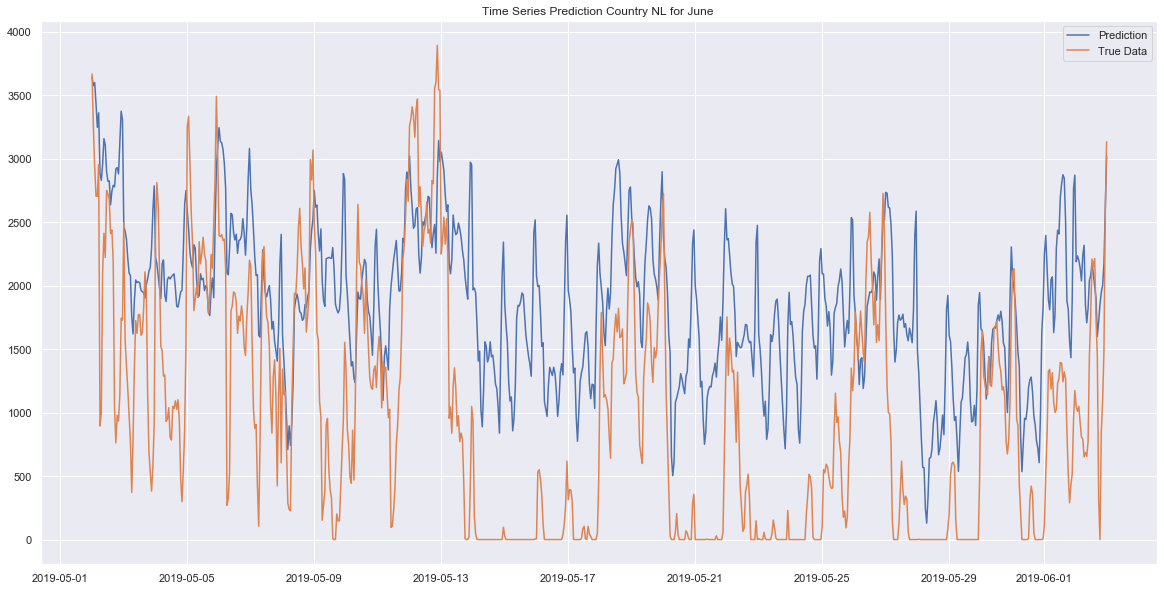

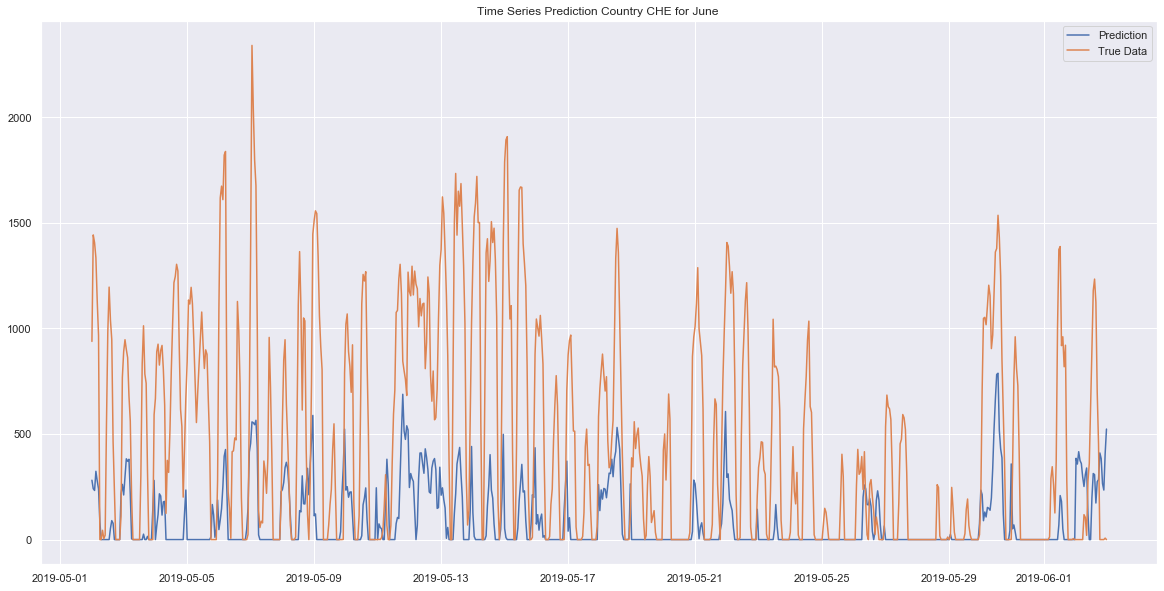

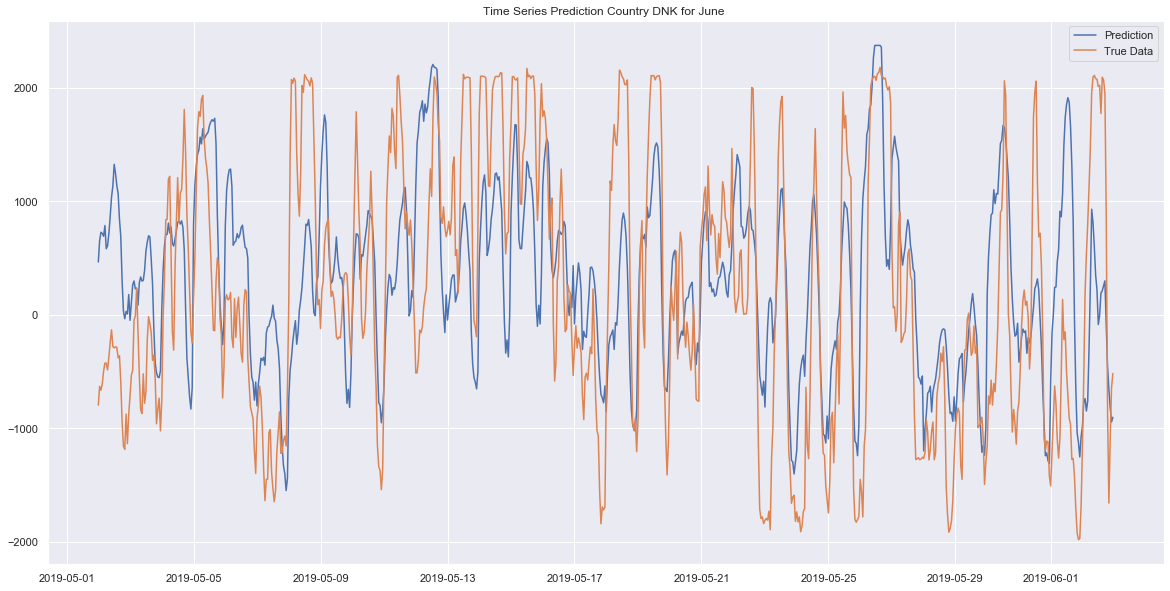

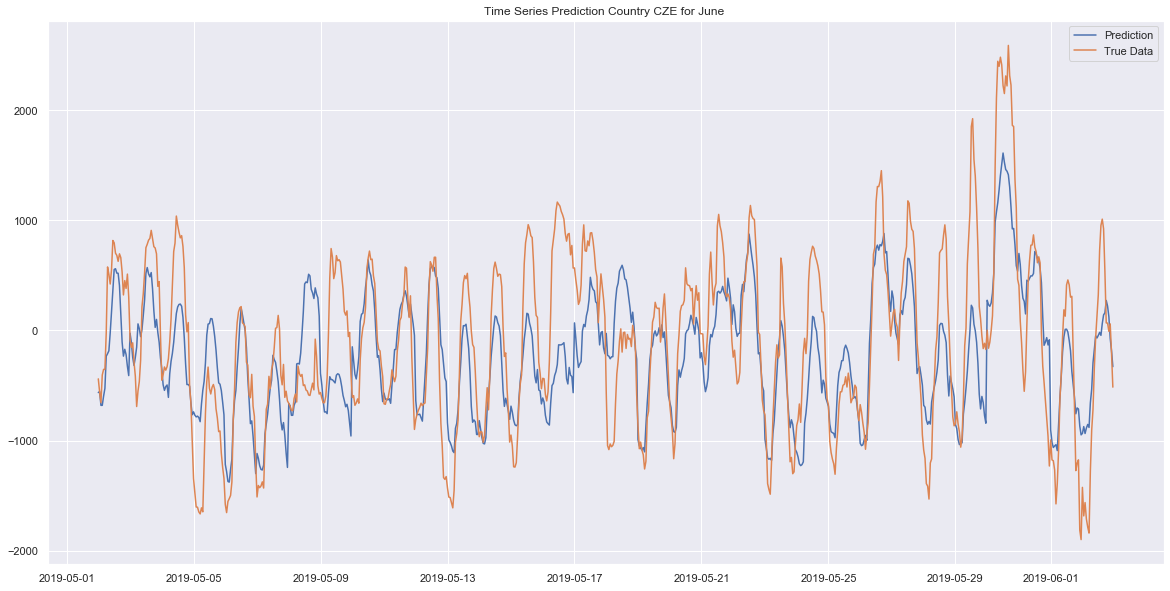

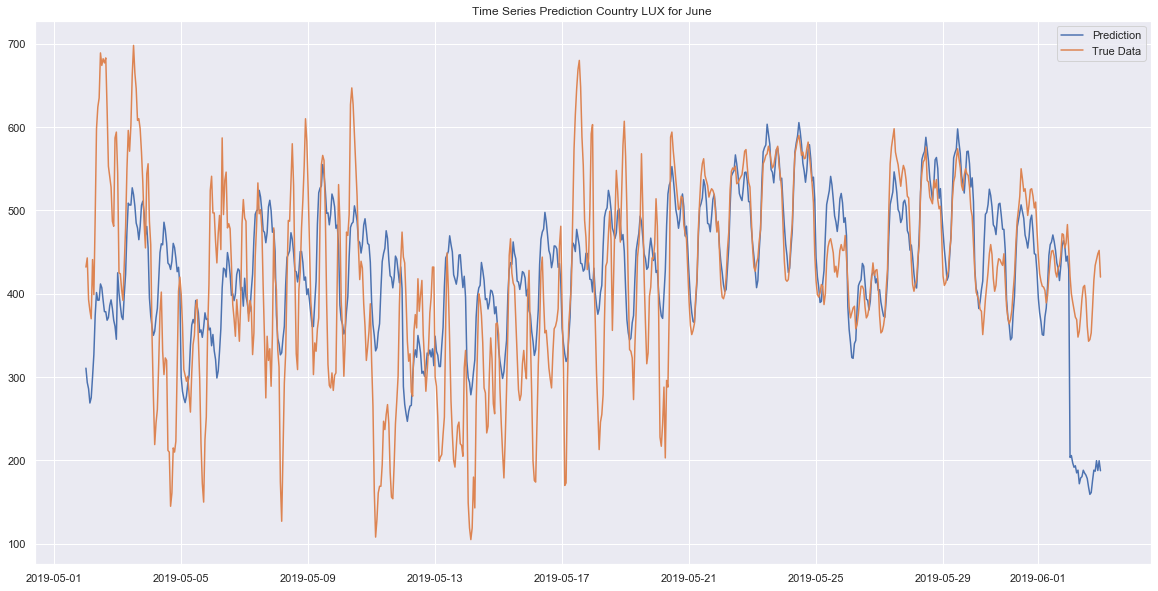

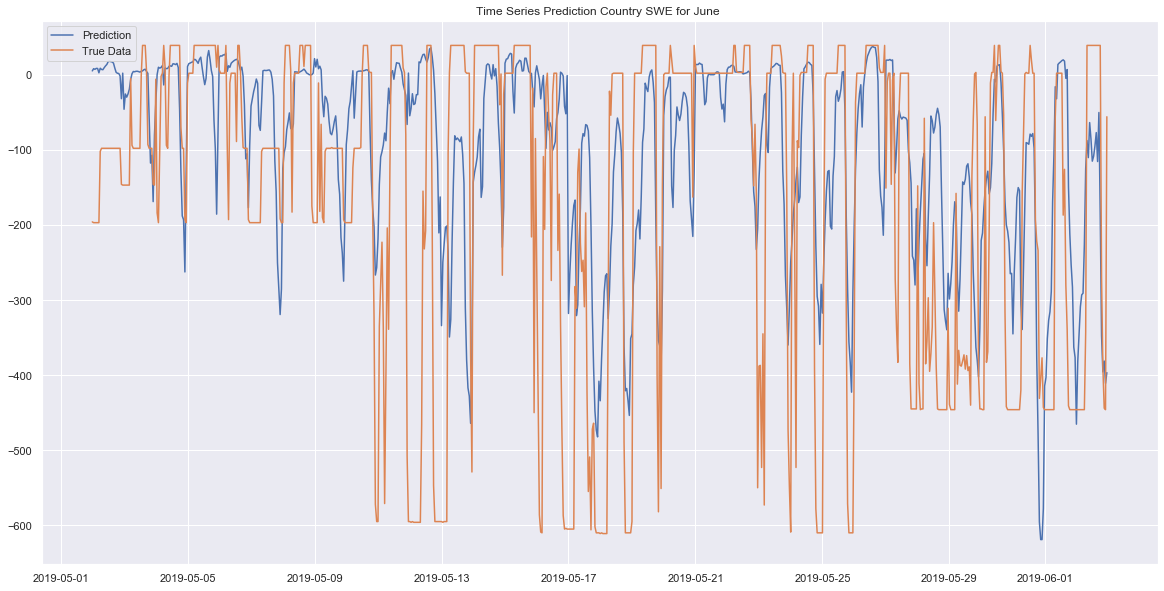

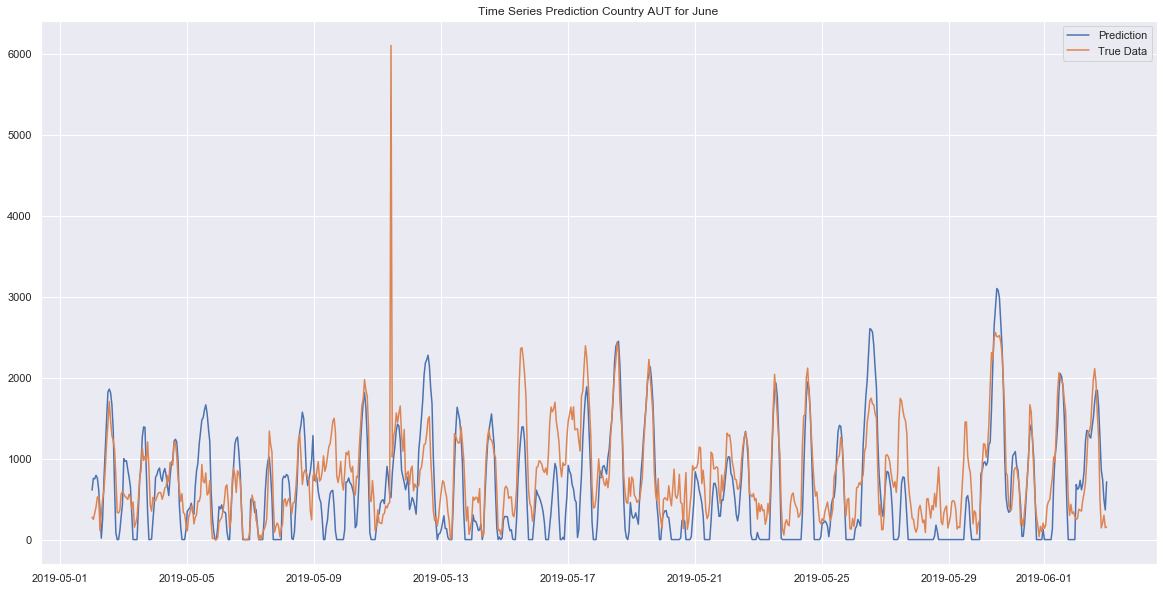

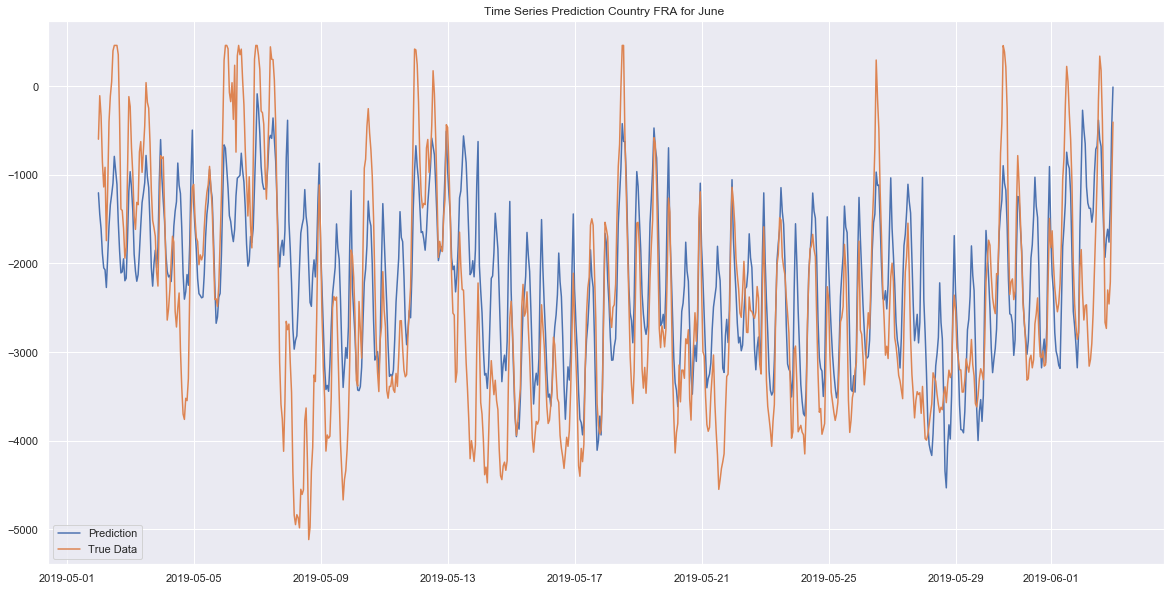

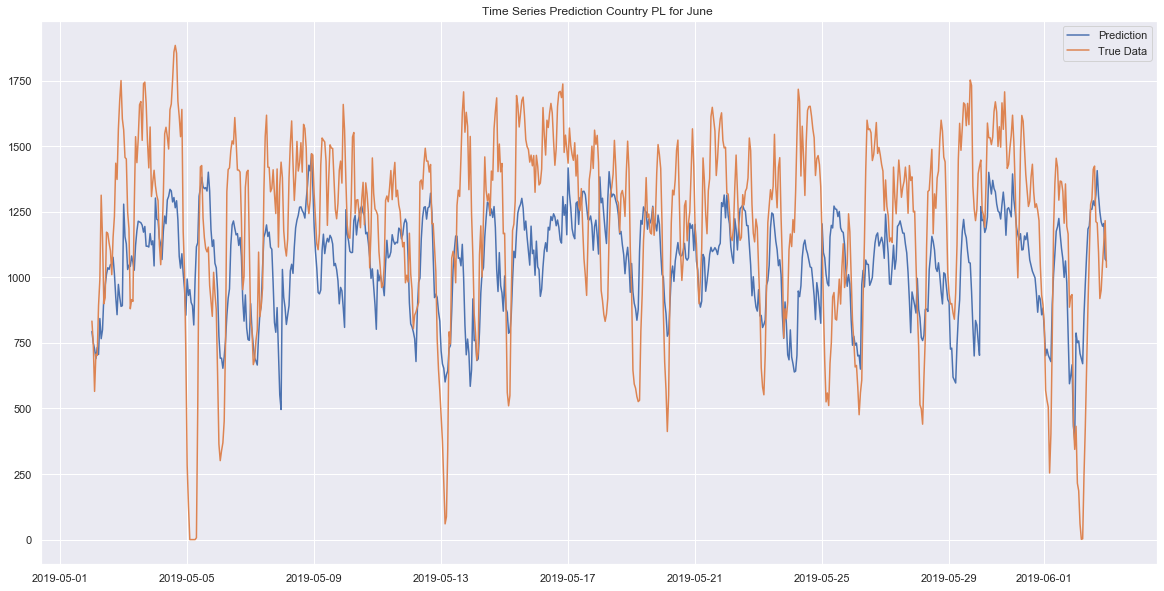

MAE:
NL     988.170881
CHE    421.296871
DNK    781.078842
CZE    413.635996
LUX     74.647817
SWE    131.848726
AUT    359.172287
FRA    716.377216
PL     277.680249
dtype: float64

Gesamt:462.656542789171


In [38]:
df_predictions = pd.read_csv('model/cnn_lstm/df_predictions.csv',sep=";",index_col=0,parse_dates=['Tag'])
df_true_eval_values = pd.read_csv('model/cnn_lstm/df_true_test_values.csv',sep=";",index_col=0,parse_dates=['Tag'])

cols = ['NL', 'CHE', 'DNK', 'CZE', 'LUX', 'SWE', 'AUT','FRA', 'PL']
evaluation.plot_and_calculate_error(df_predictions,df_true_eval_values,cols) 

### Results of Model Selection, Training, and Evaluation
* CNN + LSTM produce the best results with an MAE between 74 and 989 depending on the border.
* Autoregressive models can serve as benchmarks for advanced models and create additional insights.
* 3 years of data might not be sufficient enough data points for neural networks.
* Forecast results suggest there are important external factors not yet included in the input data. 
* Manual hyperparameter tuning not feasible due to network complexity.
* Automatic hyperparameter tuning not feasible due to computational resource limitations.

---

## 5. Conclusion

* Success of machine learning projects **depends heavily on available data**. 
* Preprocessing is a costly activity and requires major allocation of project resources and coordination efforts. 
* **Agile project management** is well suited for small machine learning projects, as it facilitates rapid iteration and prototyping.
* LSTMs handle time series data well while requiring a comparatively limited number of nodes and only a simple net topology.
* **LSTMs can be combined with CNNs for feature extraction**, which results in better accuracy, but increases net complexity significantly. 

---

----

By: Lukas Petry, Ömer Özumerzifon, Laruin Eichberger, Fabio Costa, Nevena Nikolajevic, Hendrik Scherner